In [48]:
import numpy as np
import pandas as pd
import xgboost
import sklearn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [49]:
# step1：去掉数据不完整的行
df = pd.read_csv("2017.csv").dropna()
# step2：性别、是否吸烟等特征转one-hot
df = pd.get_dummies(df, columns=['sex','SMK_STAT_TYPE_RSPS_CD'])
# step3: 去掉creatinine高于2.5的样本
df = df.loc[(df["CREATININE "]<=2.5)&(df["CREATININE "]>=0.0)]
# step4: 切分训练集与测试集
df_train = df[0:900000]; df_test = df[900000:990112] 

In [50]:
# step5: 训练集与测试集下采样
intervals = [(i * 0.1 + 0.05, i * 0.1 + 0.15) for i in range(25)]

temp_train, temp_test = [], []

for index, (low, high) in enumerate(intervals):
    
    df_sample_train = df_train.loc[(df_train["CREATININE "] > low) & (df_train["CREATININE "] < high)]
    df_sample_test  = df_test.loc[(df_test["CREATININE "] > low) & (df_test["CREATININE "] < high)]
    
    if index in range(3, 14): df_sample_train = df_sample_train.sample(2500)
    if index in range(3, 16): df_sample_test  = df_sample_test.sample(100)
    
    temp_train.append(df_sample_train)
    temp_test.append(df_sample_test)

df_train = pd.concat(temp_train, ignore_index=True)
df_test = pd.concat(temp_test, ignore_index=True)
df_train = shuffle(df_train)

# step6: 选取特征x与目标y
y_train = df_train["CREATININE "].values.reshape(-1, 1)
x_train = df_train.drop(columns=["id", "sido", "CREATININE ", "GFR", "stage", "height", "weight"]).values

y_test = df_test["CREATININE "].values.reshape(-1, 1)
x_test = df_test.drop(columns=["id", "sido", "CREATININE ", "GFR", "stage", "height", "weight"]).values

[0.6370859742164612, 0.3929747939109802, 0.14838647842407227, 0.08848017454147339, 0.33273521065711975, 0.5743451714515686, 0.7595062255859375, 0.9915297627449036, 1.2636834383010864, 1.5074856281280518]
[0.6304458379745483, 0.39374980330467224, 0.14771504700183868, 0.08822024613618851, 0.33275800943374634, 0.5774822235107422, 0.7626438140869141, 1.0010645389556885, 1.2545562982559204, 1.4794358015060425]
[0]	validation_0-rmse:0.45568	validation_0-custom_eval:0.36830	validation_1-rmse:0.53897	validation_1-custom_eval:0.43688
[0.6393394470214844, 0.3895667493343353, 0.14813630282878876, 0.08186188340187073, 0.3210941553115845, 0.554251492023468, 0.7310115694999695, 0.9551317691802979, 1.2202403545379639, 1.4605088233947754]
[0.6330176591873169, 0.39089131355285645, 0.14703220129013062, 0.080878846347332, 0.32007986307144165, 0.5572261214256287, 0.7299605011940002, 0.9682490825653076, 1.2075715065002441, 1.4292410612106323]
[1]	validation_0-rmse:0.44277	validation_0-custom_eval:0.35814	v

array([[<Axes: title={'center': '0'}>]], dtype=object)

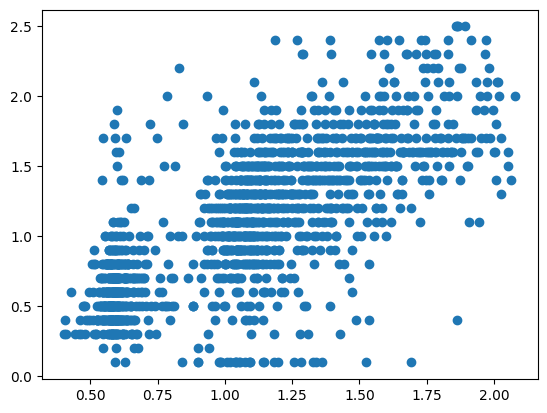

<Figure size 640x480 with 0 Axes>

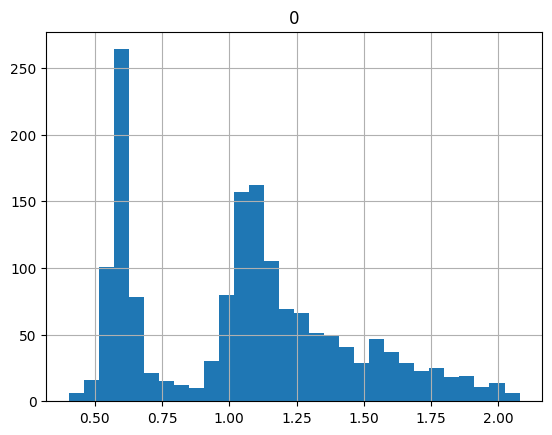

In [53]:
# step7: 使用自定义loss_func与自定义eval_metric训练模型，，计算预测值与真实值的R2
mean_value = df["CREATININE "].mean()

weights = [1] * 10

intervals = [0.1 * i * (df['CREATININE '].max() - df['CREATININE '].min()) + df['CREATININE '].min() for i in range(0, 11)]
intervals[10] += 0.001

def custom_loss(true,pred):

    error = pred - true
    
    global weights, intervals
    
    for i in range(len(true)):
        
        for j in range(0, len(intervals)-1):
            
            if intervals[j] <= true[i] < intervals[j+1]:
                error[i] = error[i] * (weights[j] / np.mean(weights))
                break
                
    grad = error
    
    return grad, np.ones_like(pred)

def custom_eval(true, pred):

    error_sum, sample_count = [0] * 10, [0] * 10
    
    global weights, intervals
    
    for i in range(len(true)):
        
        error_abs = abs(true[i] - pred[i])
        
        for j in range(0, len(intervals)-1):
            
            if intervals[j] <= true[i] < intervals[j+1]:
                error_sum[j] += error_abs
                sample_count[j] += 1
                break

    weights = [error_sum[j] / sample_count[j] if sample_count[j] > 0 else 0 for j in range(10)]

    print([float(weight) for weight in weights])
  
    return np.mean(abs(pred-true))

model = xgboost.XGBRegressor(
            max_depth=10, n_estimators=500, learning_rate=0.05, base_score = mean_value,
            min_child_weight=100, nthread=4, subsample=1, early_stopping_rounds=10, 
            colsample_bytree=1, reg_alpha=0, reg_lambda=0, gamma=0,
            eval_metric=custom_eval, objective=custom_loss,seed=10
        )

model.fit(
    x_train, y_train, verbose=1, 
    eval_set=[(x_train, y_train),(x_test, y_test)],  
    
)

print("R2指数：",model.score(x_test, y_test))

plt.figure()
test_pred = model.predict(x_test)
plt.scatter(test_pred,y_test)

plt.figure()
test_pred = model.predict(x_test)
pd.DataFrame(test_pred).hist(bins=30)

# effect of custom loss

([<matplotlib.axis.XTick at 0x148c51690>,
 [Text(0, 0, 'subset1'),
  Text(1, 0, 'subset2'),
  Text(2, 0, 'subset3'),
  Text(3, 0, 'subset4'),
  Text(4, 0, 'subset5'),
  Text(5, 0, 'subset6'),
  Text(6, 0, 'subset7'),
  Text(7, 0, 'subset8'),
  Text(8, 0, 'subset9'),
  Text(9, 0, 'subset10')])

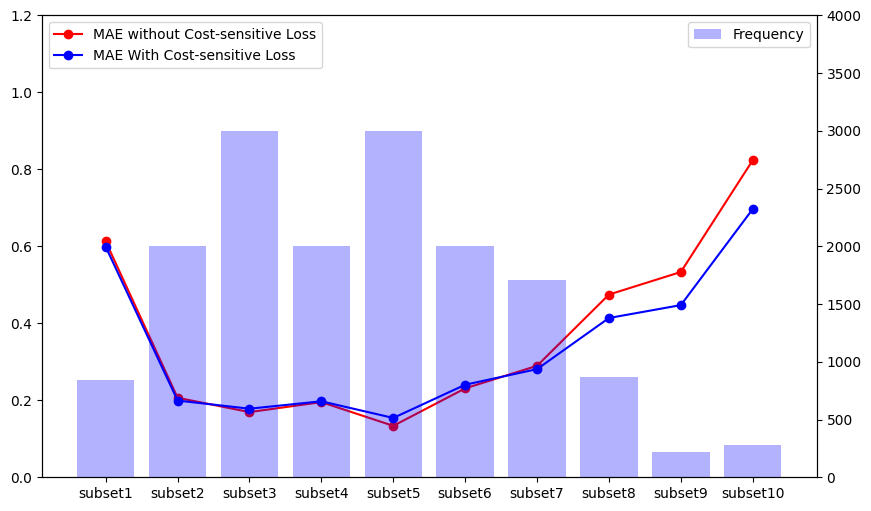

In [57]:
l = np.arange(0, 10, 1)
y1=[0.6125,0.2065,0.1693,0.1952,0.1336,0.2309,0.2896,0.4746,0.5332,0.8235]
y2=[0.5987,0.1993,0.1781,0.1974,0.1541,0.2404,0.2809,0.4137,0.4472,0.6967]
y3=[840,2000,3000,2000,3000,2000,1710,870,220,280]
x =["subset1","subset2","subset3","subset4","subset5","subset6","subset7","subset8","subset9","subset10"]

fig = plt.figure()  
ax1 = fig.add_subplot(111)  
ax1.plot(l, y1,'or-',label='MAE without Cost-sensitive Loss');
ax1.plot(l, y2,'ob-',label='MAE With Cost-sensitive Loss');
ax1.legend(loc=2)
ax1.set_ylim([0.0, 1.2]);

ax2 = ax1.twinx()
plt.bar(l,y3,alpha=0.3,color='blue',label='Frequency')  
ax2.legend(loc=1)
ax2.set_ylim([0, 4000])

params = {'figure.figsize': '10, 10'}
plt.rcParams.update(params)

plt.xticks(l,x)

# Important Factors Analysis

/Users/wangweilun/miniconda3/envs/ChronicKidneyDisease/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R2指数： 0.5389331342186013
'age'  with:   np.float64(0.11063310478043971)
'waist'  with:   np.float64(0.04251926201008644)
'vision_left'  with:   np.float64(0.007744774288171409)
'vision_right'  with:   np.float64(0.010093112993377024)
'listen_left'  with:   np.float64(0.0009002545760505935)
'listen_right'  with:   np.float64(0.0008838308623580318)
'BP_HIGH '  with:   np.float64(0.00854619631531484)
'BP_LWST '  with:   np.float64(0.004708051159148454)
'BLDS'  with:   np.float64(0.012121213773932233)
'TOT_CHOLE '  with:   np.float64(0.00848500056976313)
'TRIGLYCERIDE'  with:   np.float64(0.01298438529226523)
'HDL_CHOLE '  with:   np.float64(0.01590444350961553)
'LDL_CHOLE '  with:   np.float64(0.008091165121431664)
'HMG '  with:   np.float64(0.10435613899254985)
'OLIG_PROTE_CD'  with:   np.float64(0.07865824511308264)
'SGOT_AST '  with:   np.float64(0.0057011272117471045)
'SGPT_ALT '  with:   np.float64(0.007520692484593983)
'GAMMA_GTP '  with:   np.float64(0.012104837919977622)
'DRINK_OR

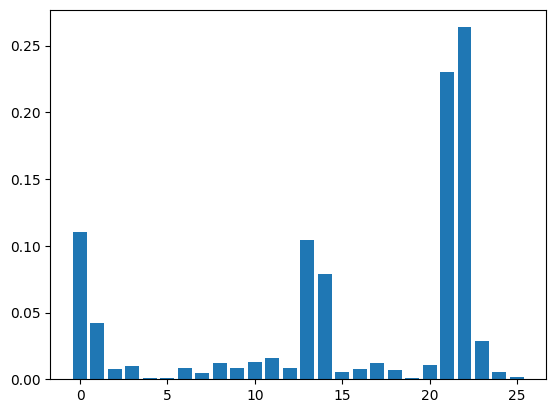

In [11]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    criterion="squared_error",n_estimators=100,max_depth=10, 
    min_samples_split=40,min_samples_leaf=7,
    max_features=7,oob_score=True, random_state=10
)
model.fit(x_train, y_train)
print("R2指数：",model.score(x_test, y_test))

importances = model.feature_importances_
columns = df_train.drop(columns=["id", "sido", "CREATININE ", "GFR", "stage", "height", "weight"]).columns.values

for column,importance in zip(columns,importances):
    
    print("%r  with:   %r" % (column,importance))
    
plt.bar(range(len(columns)), importances)
plt.show()